# Springboard Data Science Track Capstone Project 1
### Histopathologic Cancer Detection
### by Morgan Fry
### Statistical Analysis notebook

In [1]:
#includes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
%matplotlib inline

from matplotlib.image import imread
import cv2    

from sklearn.utils import shuffle
import pickle
import sys
import seaborn as sns

from numpy.random import seed

from scipy.stats import pearsonr

from scipy import stats
import statsmodels.api as sm

import scipy.stats as st

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
#load data saved in data wrangling notebook
y=pickle.load(open("y_s.p","rb"))
X=pickle.load(open("X_s.p","rb"))

In [4]:
#crop and put in dataframe
X_v_d={}
for each in X.items():
    X_v_d.update({each[0]:each[1][31:63,31:63].flatten()})


In [5]:
X_v_df=pd.DataFrame.from_dict(X_v_d,orient='index')

In [6]:
#merge with labels
Xy_df=X_v_df.merge(y,right_on='id',left_index=True)

In [7]:
Xy_p_df=Xy_df[Xy_df['label']==1]
Xy_n_df=Xy_df[Xy_df['label']==0]
Xy_n_df=Xy_n_df.iloc[:len(Xy_p_df)]

In [9]:

pcorr=Xy_p_df.iloc[0:3071].corr()
ncorr=Xy_n_df.iloc[0:3071].corr()


We can plot a correlation matrix for all of the pixels. This will show us if there are any frequent shapes in the set plotted. For instance, if the pixel(16,16) frequently had a similar color across all samples it would be hightly correlated. We can infer from the plot below that there is some correlation between each pixel and its neighbors, but not much else. The Looking at it this way is not very fruitful when it comes to building a classification model. If we look at a few of the slides, we can see why -- we are looking at biological cells of a variety of shape.

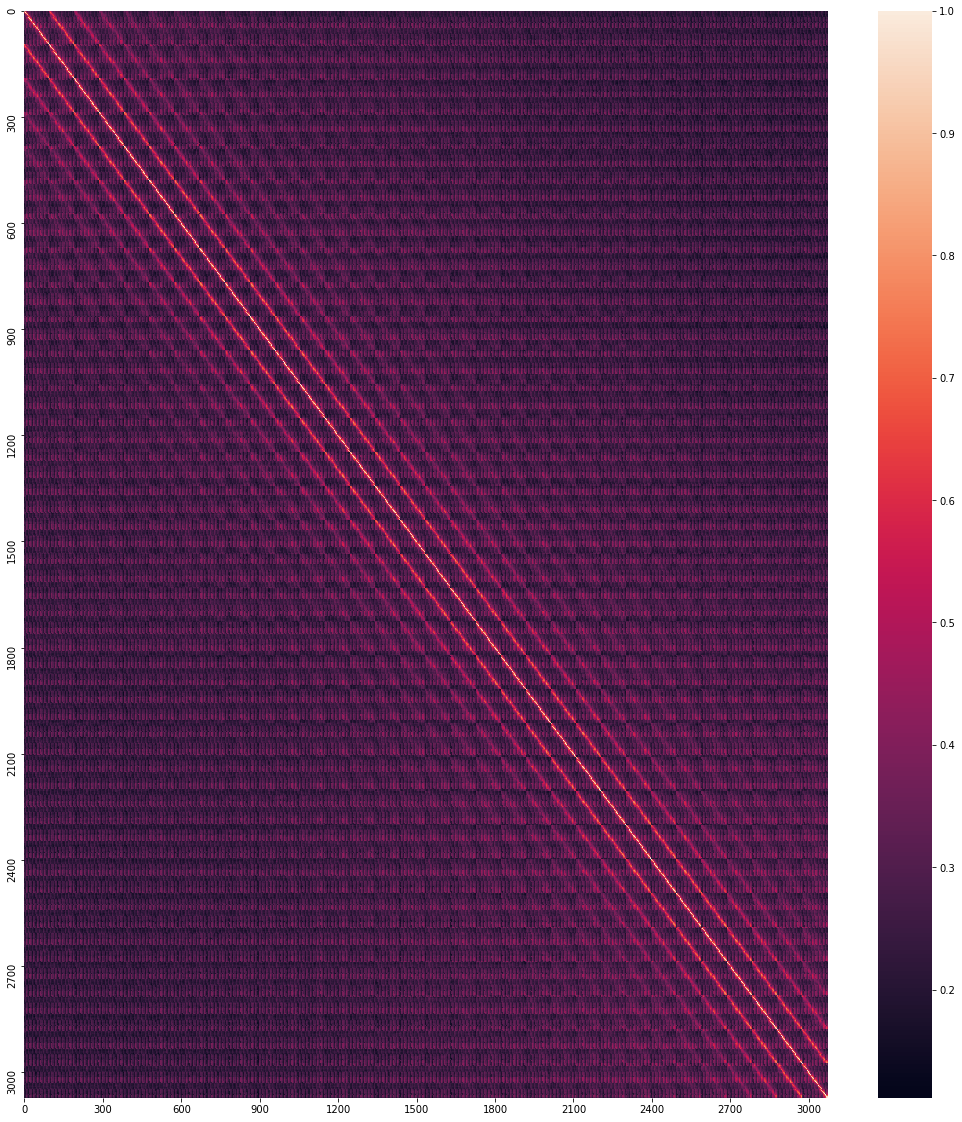

In [11]:
plt.figure(figsize=(18,20))
ax=sns.heatmap(pcorr,xticklabels=300,yticklabels=300)

plt.show()

In [ ]:
plt.figure(figsize=(18,20))
ax=sns.heatmap(ncorr,xticklabels=300,yticklabels=300)
ax.set_title('Negative correlation matrix')
plt.show()

The corerlation has a few regular bands of decreasing correlation in parallel with the center diagonal (where x=y). We can intuit from this that these bands represent each pixel's nearest vertical neighbors

These slides have all been treated with a contrast dye, which brings out a particular color in cancerous cells. Given that, it should be more fruitful to look for that color. Since each color is simply a tuple (b,r,g) if we put each color channel in a column and concatenate the images so that each row of the dataframe represents a pixel (and every 1024 rows a new image), a correlation between two colors will map to a preponerance of a particular hue in the image.

In [12]:
#first sort the positive and negative slides into lists. 
X_p,X_n=[],[]
for idx,row in y.iterrows():
    if row.label==1:
        X_p.append(X.get(row.id))       
    else:
        X_n.append(X.get(row.id))

X_n=shuffle(X_n)[:len(X_p)] #truncate negative group to same size as positive

In [13]:
#crop
X_p_c=[a[31:63,31:63] for a in X_p]
X_n_c=[a[31:63,31:63] for a in X_n]

#also flatten into 1d
X_p_v=[a.flatten() for a in X_p_c]
X_n_v=[a.flatten() for a in X_n_c]

In [14]:
#we'll look at correlations for each of the three color channels
#X_n_c_s=X_n_c[:len(X_p_c)] #truncating the lists so we have the same number of pos and neg samples
bp,gp,rp,bn,gn,rn=[],[],[],[],[],[]
for each in X_p:
    b,g,r=cv2.split(each)
    bp.append(b)
    gp.append(g)
    rp.append(r)
for each in X_n:
    b,g,r=cv2.split(each)
    bn.append(b)
    gn.append(g)
    rn.append(r)
    
#now the cropped samples
bpc,gpc,rpc,bnc,gnc,rnc=[],[],[],[],[],[]
for each in X_p_c:
    b,g,r=cv2.split(each)
    bpc.append(b)
    gpc.append(g)
    rpc.append(r)
for each in X_n_c:
    b,g,r=cv2.split(each)
    bnc.append(b)
    gnc.append(g)
    rnc.append(r)
    
#get mean and variance for comparison
color_channels=[bp,bpc,gp,gpc,rp,rpc,bn,bnc,gn,gnc,rn,rnc]
col_means,col_var=[],[]

for each in color_channels:
    col_means.append([np.mean(a) for a in each])
    col_var.append([np.var(a) for a in each])
    


In [15]:
#first split the color channels
X_n_c_s=X_n_c[:len(X_p_c)] #truncating the lists so we have the same number of pos and neg samples
bp,gp,rp,bn,gn,rn=[],[],[],[],[],[]
for each in X_p_c:
    b,g,r=cv2.split(each)
    bp.append(b)
    gp.append(g)
    rp.append(r)
for each in X_n_c_s:
    b,g,r=cv2.split(each)
    bn.append(b)
    gn.append(g)
    rn.append(r)
    
#flatten into arrays
bpa=np.array(bp).flatten()
gpa=np.array(gp).flatten()
rpa=np.array(rp).flatten()
bna=np.array(bn).flatten()
gna=np.array(gn).flatten()
rna=np.array(rn).flatten()

In [16]:
bpm=[np.mean(a) for a in bp]
gpm=[np.mean(a) for a in gp]
rpm=[np.mean(a) for a in rp]
bnm=[np.mean(a) for a in bn]
gnm=[np.mean(a) for a in gn]
rnm=[np.mean(a) for a in rn]

In [17]:
dpm={'Blue':bpm,'Green':gpm,'Red':rpm}
dnm={'Blue':bnm,'Green':gnm,'Red':rnm}
X_p_mean_df=pd.DataFrame(data=dpm)
X_n_mean_df=pd.DataFrame(data=dnm)
X_p_mean_df['Label']=1
X_n_mean_df['Label']=0
X_mean_df=X_p_mean_df.append(X_n_mean_df)

In [18]:
#arrange data into dataframes to pass to seaborn
d={'bp':bpa,'gp':gpa,'rp':rpa,'bn':bna,'gn':gna,'rn':rna}
dp={'Blue':bpa,'Green':gpa,'Red':rpa}
dn={'Blue':bna,'Green':gna,'Red':rna}

X_p_df=pd.DataFrame(data=dp)
X_n_df=pd.DataFrame(data=dn)
X_p_df['Label']=1
X_n_df['Label']=0
X_df=X_p_df.append(X_n_df)

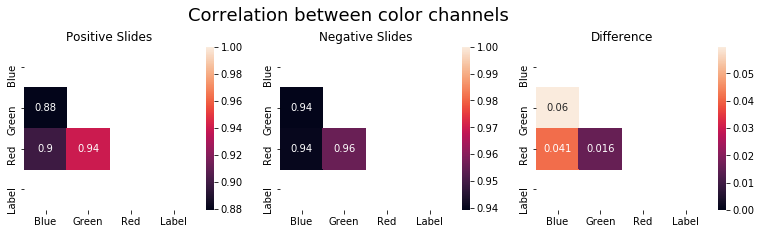

In [19]:
#plot the correlation matrix
fig,axs = plt.subplots(1,3, figsize=(13,3))
fig.text(x=0.3,y=1,s='Correlation between color channels',fontsize=18)
corrp=X_p_df.corr()
corrn=X_n_df.corr()
corrdiff=abs(corrp-corrn)
mask = np.triu(np.ones_like(corrp, dtype=np.bool))
sns.heatmap(corrp,ax=axs[0],mask=mask,annot=True).set_title('Positive Slides')
sns.heatmap(corrn,ax=axs[1],mask=mask,annot=True).set_title('Negative Slides')
sns.heatmap(corrdiff,ax=axs[2],mask=mask,annot=True).set_title('Difference')
plt.show()

Now let's plot each of the 3 2-d color spaces for both positive and negative (blue/green, blue/red, and green/red) and see if there is a useful difference in the hue of the positive vs the negative groups.

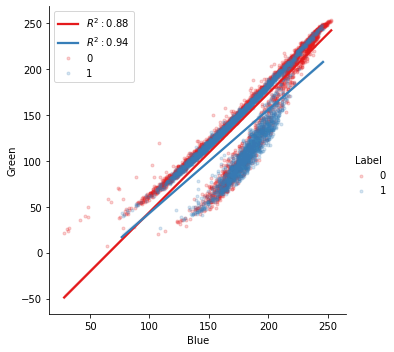

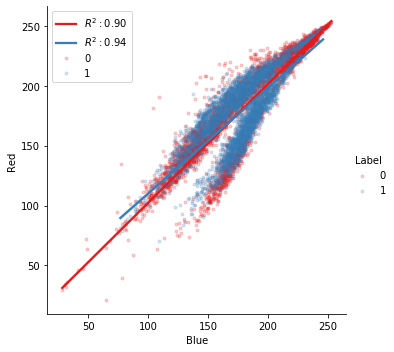

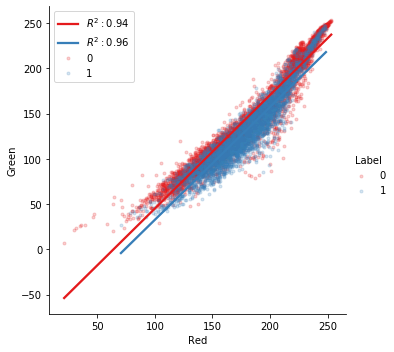

In [20]:
p = sns.lmplot(x='Blue',y='Green',data=X_mean_df,hue='Label',
               palette='Set1',markers='.',scatter_kws={'alpha':0.2},
               line_kws={'label':"Linear Reg"},aspect=1)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
# assuming you computed r_squared which is the coefficient of determination somewhere else
slope, intercept, r_value, p_value, std_err = stats.linregress(X_p_df['Blue'],X_p_df['Green'])
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(X_n_df['Blue'],X_n_df['Green'])

label_line_1 = r'$R^2:{0:.2f}$'.format(r_value)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value1) # as an exampple or whatever you want[!
L_labels[0].set_text(label_line_1)
L_labels[1].set_text(label_line_2)

p = sns.lmplot(x='Blue',y='Red',data=X_mean_df,hue='Label',
               palette='Set1',markers='.',scatter_kws={'alpha':0.2},
               line_kws={'label':"Linear Reg"},aspect=1)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
# assuming you computed r_squared which is the coefficient of determination somewhere else
slope, intercept, r_value, p_value, std_err = stats.linregress(X_p_df['Blue'],X_p_df['Red'])
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(X_n_df['Blue'],X_n_df['Red'])

label_line_1 = r'$R^2:{0:.2f}$'.format(r_value)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value1) # as an exampple or whatever you want[!
L_labels[0].set_text(label_line_1)
L_labels[1].set_text(label_line_2)

p = sns.lmplot(x='Red',y='Green',data=X_mean_df,hue='Label',
               palette='Set1',markers='.',scatter_kws={'alpha':0.2},
               line_kws={'label':"Linear Reg"},aspect=1)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
# assuming you computed r_squared which is the coefficient of determination somewhere else
slope, intercept, r_value, p_value, std_err = stats.linregress(X_p_df['Red'],X_p_df['Green'])
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(X_n_df['Red'],X_n_df['Green'])

label_line_1 = r'$R^2:{0:.2f}$'.format(r_value)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value1) # as an exampple or whatever you want[!
L_labels[0].set_text(label_line_1)
L_labels[1].set_text(label_line_2)

We can see from the above that the difference between the positive and negative groups across the blue/red and blue/green planes are greater than across the red/green plane. Let's use a statsmodel OLS regression to look in a little more detail.

In [21]:
m = ols('Blue ~ Green + Red',X_p_df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   Blue   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                 9.163e+06
Date:                Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:11:29   Log-Likelihood:            -1.7948e+07
No. Observations:             4071424   AIC:                         3.590e+07
Df Residuals:                 4071421   BIC:                         3.590e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.4115      0.045   1115.895      0.0

In [22]:
m = ols('Blue ~ Green + Red',X_n_df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   Blue   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 1.896e+07
Date:                Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:00:47   Log-Likelihood:            -1.7679e+07
No. Observations:             4071424   AIC:                         3.536e+07
Df Residuals:                 4071421   BIC:                         3.536e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.4690      0.036   1240.413      0.0

In summary, the correlations between the blue/green and blue/red pair of colors in any given pixel are a little stronger in the negative than the positive group, and the slope and intercept of the regression lines is different. This may inform our model building at a later step, but it is not enough to accurately classify the images yet.

In addition we can 